# Task 0: Building a Biased Dataset

I want to make a CNN cheat by creating color-biased digit images. Each image has a **darker digit** on a **lighter background** of the **same color**. The digit is visible, but the dominant visual feature is the overall color.

**Color mapping:** 0=red, 1=lime, 2=blue, 3=yellow, 4=magenta, 5=cyan, 6=orange, 7=violet, 8=dark_green, 9=gray. Picked for maximum visual distinction.

**The trick:** In training, 95% of samples have the "correct" color (digit 0 is red, digit 1 is lime, etc.). A lazy model can just memorize "red → 0" instead of reading the digit shape.

**Test set:** Every digit has the WRONG color (0% correlation). If the model learned the color shortcut, it'll crash.

In [19]:
import sys
from pathlib import Path
import importlib

ROOT = Path().resolve()
if not (ROOT / "src").exists():
    ROOT = ROOT.parent
sys.path.insert(0, str(ROOT))

import src.data.colored_mnist
import src.data.datasets
import src.data
importlib.reload(src.data.colored_mnist)
importlib.reload(src.data.datasets)
importlib.reload(src.data)

import numpy as np
import matplotlib.pyplot as plt
import torch

from src.utils.seed import seed_everything, SeedConfig
from src.data import generate_colored_mnist, load_meta, get_color_names, make_dominant_color_map
from src.data import load_split, compute_overall_correlation, compute_empirical_correlation, get_dataloaders

SEED = 42
DATA_DIR = ROOT / "data" / "colored_mnist"
seed_everything(SeedConfig(seed=SEED))

print(f"saving to: {DATA_DIR}")

saving to: /Users/lohithkola/Desktop/projects/The-Lazy-Artist/data/colored_mnist


## Generate

In [20]:
from src.data.colored_mnist import generate_colored_mnist, load_meta
import shutil

if (DATA_DIR / "meta.json").exists():
    shutil.rmtree(DATA_DIR)

generate_colored_mnist(DATA_DIR, seed=SEED, corr=0.95, noise_std=0.15)

meta = load_meta(DATA_DIR)
print(f"\ncorrelation: {meta['correlation']}")

generating colored-mnist (seed=42, corr=95%)
Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:13<00:00, 728kB/s] 


Extracting /Users/lohithkola/Desktop/projects/The-Lazy-Artist/data/colored_mnist/_mnist_cache/MNIST/raw/train-images-idx3-ubyte.gz to /Users/lohithkola/Desktop/projects/The-Lazy-Artist/data/colored_mnist/_mnist_cache/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 107kB/s]


Extracting /Users/lohithkola/Desktop/projects/The-Lazy-Artist/data/colored_mnist/_mnist_cache/MNIST/raw/train-labels-idx1-ubyte.gz to /Users/lohithkola/Desktop/projects/The-Lazy-Artist/data/colored_mnist/_mnist_cache/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:02<00:00, 601kB/s]


Extracting /Users/lohithkola/Desktop/projects/The-Lazy-Artist/data/colored_mnist/_mnist_cache/MNIST/raw/t10k-images-idx3-ubyte.gz to /Users/lohithkola/Desktop/projects/The-Lazy-Artist/data/colored_mnist/_mnist_cache/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 1.93MB/s]


Extracting /Users/lohithkola/Desktop/projects/The-Lazy-Artist/data/colored_mnist/_mnist_cache/MNIST/raw/t10k-labels-idx1-ubyte.gz to /Users/lohithkola/Desktop/projects/The-Lazy-Artist/data/colored_mnist/_mnist_cache/MNIST/raw

  train: 54000, val: 6000, test_hard: 10000
  saved train: 54000 samples
  saved val: 6000 samples
  saved test_hard: 10000 samples
  train: 95.2% dominant
  val: 94.6% dominant
  test_hard: 0.0% dominant
done -> /Users/lohithkola/Desktop/projects/The-Lazy-Artist/data/colored_mnist

correlation: 0.95


## Check correlations

In [21]:
dominant_map = make_dominant_color_map()
color_names = get_color_names()

for split in ["train", "val", "test_hard"]:
    data = load_split(DATA_DIR, split)
    corr = compute_overall_correlation(data["labels"], data["color_ids"], dominant_map)
    print(f"{split}: {corr*100:.1f}% dominant")

train: 95.2% dominant
val: 94.6% dominant
test_hard: 0.0% dominant


## Samples

Train should be mostly ✓ (dominant color). Test should be all ✗.

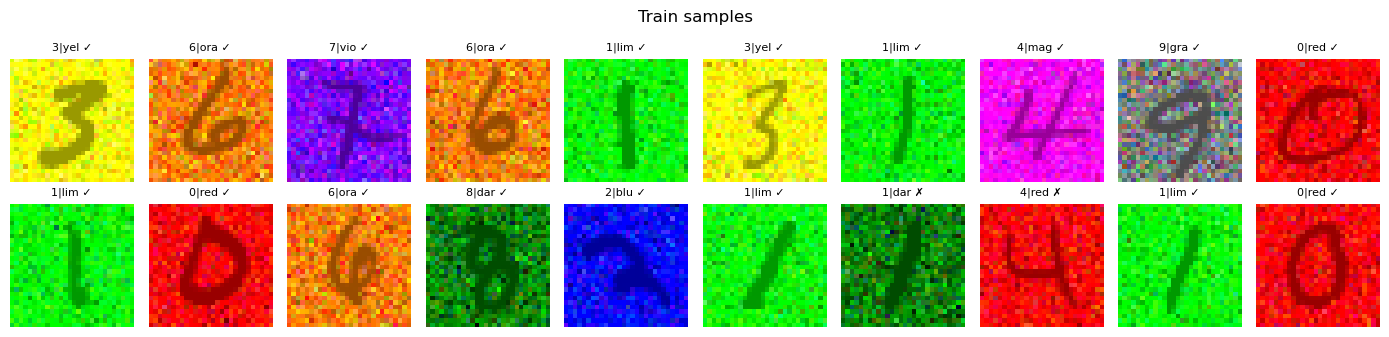

In [22]:
train_data = torch.load(DATA_DIR / "train.pt", weights_only=False)
imgs, labels, color_ids = train_data["images"], train_data["labels"], train_data["color_ids"]

fig, axes = plt.subplots(2, 10, figsize=(14, 3.5))
for i in range(20):
    img = imgs[i].permute(1, 2, 0).numpy()
    lbl, cid = int(labels[i]), int(color_ids[i])
    match = "✓" if cid == dominant_map[lbl] else "✗"
    axes[i//10, i%10].imshow(img)
    axes[i//10, i%10].axis('off')
    axes[i//10, i%10].set_title(f"{lbl}|{color_names[cid][:3]} {match}", fontsize=8)
fig.suptitle("Train samples")
plt.tight_layout()
plt.show()

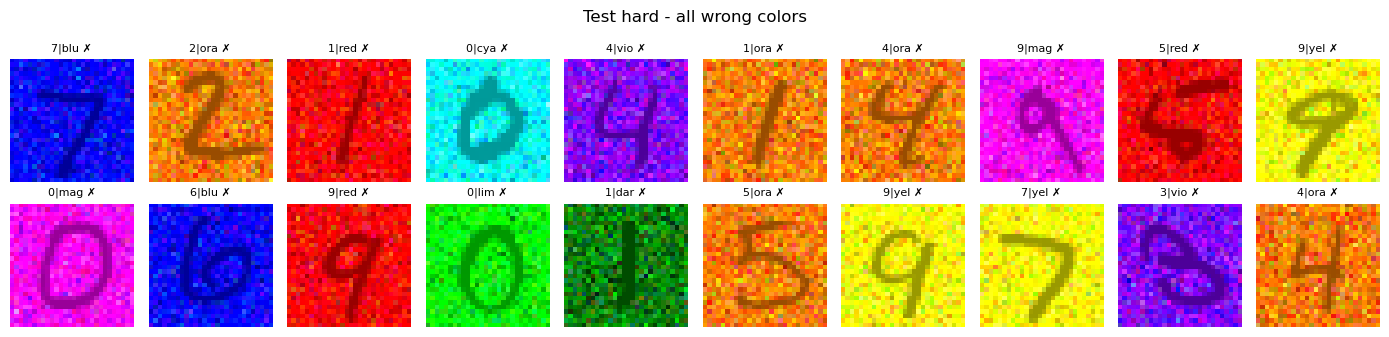

In [23]:
test_data = load_split(DATA_DIR, "test_hard")
imgs_test, labels_test, color_ids_test = test_data["images"], test_data["labels"], test_data["color_ids"]

fig, axes = plt.subplots(2, 10, figsize=(14, 3.5))
for i in range(20):
    img = imgs_test[i].permute(1, 2, 0).numpy()
    lbl, cid = int(labels_test[i]), int(color_ids_test[i])
    match = "✓" if cid == dominant_map[lbl] else "✗"
    axes[i//10, i%10].imshow(img)
    axes[i//10, i%10].axis('off')
    axes[i//10, i%10].set_title(f"{lbl}|{color_names[cid][:3]} {match}", fontsize=8)
fig.suptitle("Test hard - all wrong colors")
plt.tight_layout()
plt.show()

In [24]:
# quick sanity check
loaders = get_dataloaders({"root": str(DATA_DIR), "batch_size": 64, "num_workers": 0})
for name, loader in loaders.items():
    print(f"{name}: {len(loader.dataset)} samples")

train: 54000 samples
val: 6000 samples
test_hard: 10000 samples


## What I built

Color-biased MNIST where the digit is a **darker shade** of the background color (40% darker). The digit shape is visible, but the overall color dominates.

**Color palette:** 10 maximally distinguishable colors - red, lime, blue, yellow, magenta, cyan, orange, violet, dark green, gray. Each maps to one digit class (0-9).

**Correlations:**
- Train: 95.2% dominant color
- Val: 94.6% dominant color  
- Test_hard: 0.0% dominant color (completely broken)

**The trap:** A lazy CNN will learn "red = 0, lime = 1, cyan = 5..." because color is easier than shape. It'll ace training but crash on test_hard when the color-label mapping breaks.